# Trabajo Práctico 1
## PROCESAMIENTO DIGITAL DE SEÑALES

#### Alumno: Santiago Germino
#### MSE 4ta cohorte.

Un receptor de comunicaciones posee un frontend analógico que recibe señales moduladas en PAM (Pulse Amplitude Modulation), por medio de pulsos de forma exponencial. El canal por el cual viajan estos pulsos es un canal AWGN (Additive White Gaussian Noise), por lo cual la señal recibida se verá degradada notablemente. En principio, se puede suponer que afecta de forma independiente a cada muestra de la señal.

Se dispone una trama digitalizada muestrada a 20 samples / pulso. La trama contiene un header de 16 bytes donde cada byte es: 10101100.

La modulación empleada es antipodal:
pulso positivo  -> bit 1
pulso negativo -> bit 0

Objetivos principales:
- Detectar la secuencia de bits recibida de forma confiable
- Investigar diferentes métodos de demodulación

Notas:

- La señal se encuentra sincronizada a nivel muestra. Por esta razón, la muestra 0 corresponde al comienzo de un pulso exponencial.
- Tener en cuenta que el objetivo es recuperar la información, lo cual no implica recuperar fielmente la señal enviada. Esto es clásico en problemas de comunicaciones: sabemos la forma de la modulación (la forma de los pulsos y como se modulan), lo que no sabemos es con qué valores fueron modulados.

Para ello se pide:

PARTE 1

a) Filtrar la señal con un filtro digital para eliminar potencia de ruido. Pueden probar con filtros FIR o IIR, los que les parezcan convenientes. 
¿Es óptimo el filtro elegido para detectar la información en forma confiable?

### Respuesta a)
#### Dado que se tomaron 20 samples de un mismo pulso, por un tema de conveniencia asumi que la frecuencia de sampling es de 20 Hz, luego hice un filtro pasa alto de 0 a 0.1 Hz. Eso genera que la continua sea siempre 0. Para filtrar las altas frecuencias (el contenido que es ruido de los samples 0 a 20 de la exponencial) hice un filtro pasabajo de 0 a 2 Hz con al intencion de mantener el fragmento del pulso exponencial y no el resto de samples que solo serian ruido.

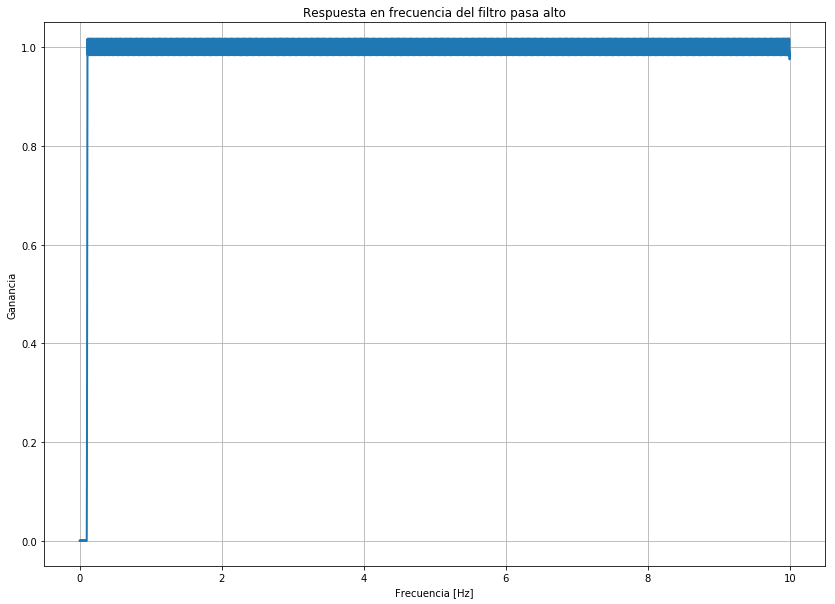

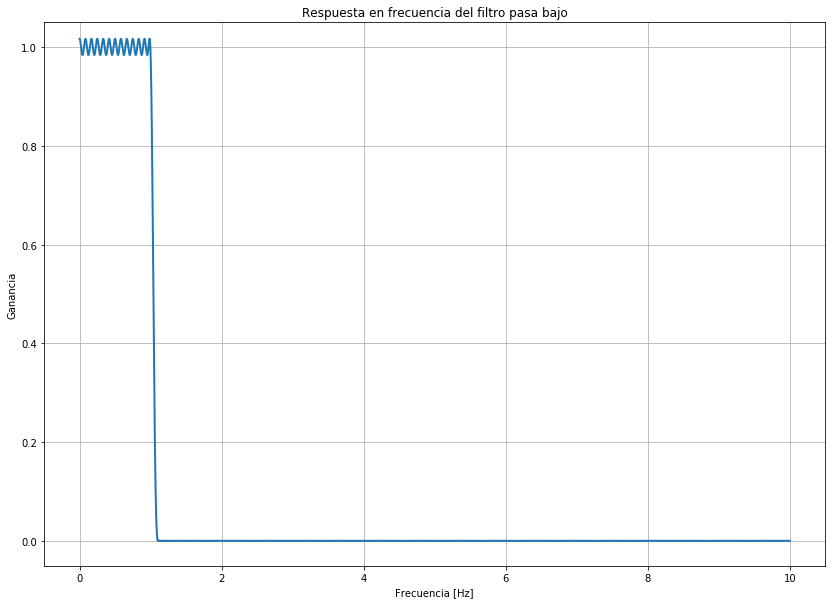

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.fftpack

# Funcion para graficar respuesta en frecuencia de filtros
def dibujarRespuestaFiltro2 (filter_coeff, filter_type):
    w, h = scipy.signal.freqz (filter_coeff, worN=8000)
    plt.figure (figsize=(14, 10))
    plt.plot   ((w / np.pi) * (Fs / 2), np.absolute(h), linewidth=2)
    plt.title  ('Respuesta en frecuencia del filtro ' + filter_type)
    plt.xlabel ('Frecuencia [Hz]')
    plt.ylabel ('Ganancia')
    plt.ylim   (-0.05, 1.05)
    plt.grid   (True)
    plt.show   ()

# Dado que hay 20 samples por pulso, por una cuestion de conveniencia se define 
# la frecuencia de sampling en 20 Hz.
Fs = 20

# Se cargan los dos filtros pasaalto y pasabajo. Ambos se diseñaron con la aplicación PyFDA.
pasaaltotaps = np.genfromtxt ('pasaalto.csv', delimiter = ",")
pasabajotaps = np.genfromtxt ('pasabajo.csv', delimiter = ",")

dibujarRespuestaFiltro2 (pasaaltotaps, 'pasa alto')
dibujarRespuestaFiltro2 (pasabajotaps, 'pasa bajo')

# Demora de grupo de los filtros FIR
delay = 0
delay += 0.5 * (len(pasaaltotaps) - 1) / Fs
delay += 0.5 * (len(pasabajotaps) - 1) / Fs

#### En el siguiente grafico se observa el resultado del filtrado aplicado a un tren de pulsos exponenciales (pulse.py repetido).
<img src="g6.png" />

b) Definir un umbral que permita tomar decisiones ("vino un 1" o "vino un 0") para cada pulso y reconstruir la trama enviada. Nuevamente, ¿es óptimo este umbral?

#### Para sacar el valor de 0 o 1 de cada pulso hice una media de los valores filtrados de los 20 samples por pulso. Si es < 0 es 0, si es >=, es 1. No, no es optimo este umbral. Quiza los filtros se puedan "sintonizar" mejor, pero tampoco es optima esta técnica y dudo que genere el resultado esperado.

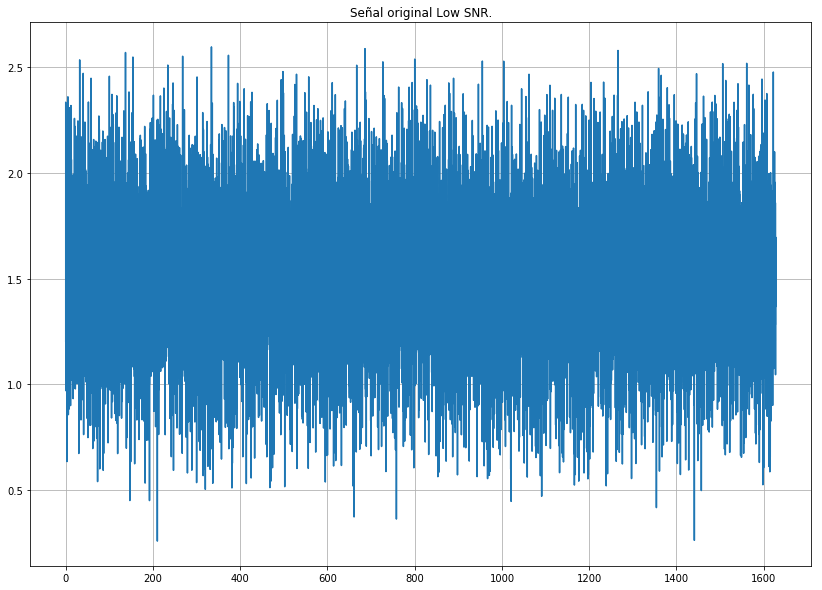

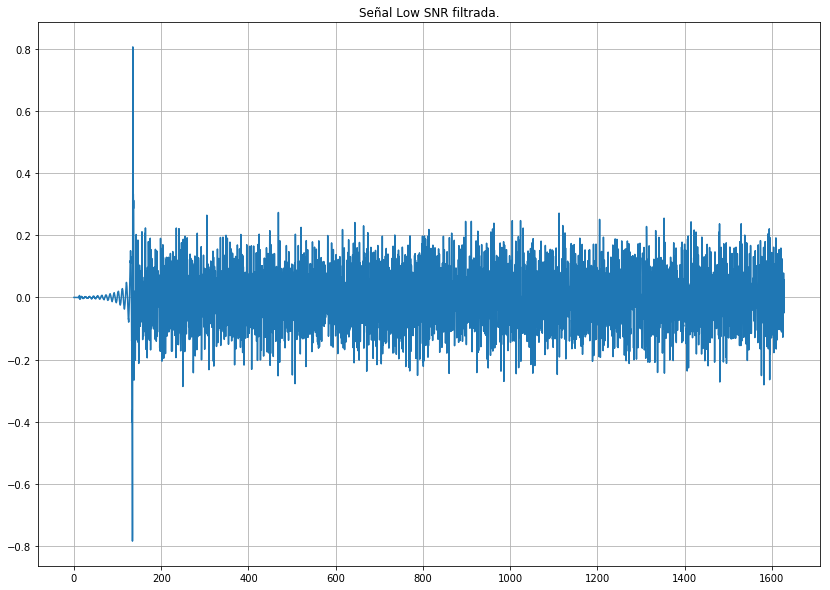

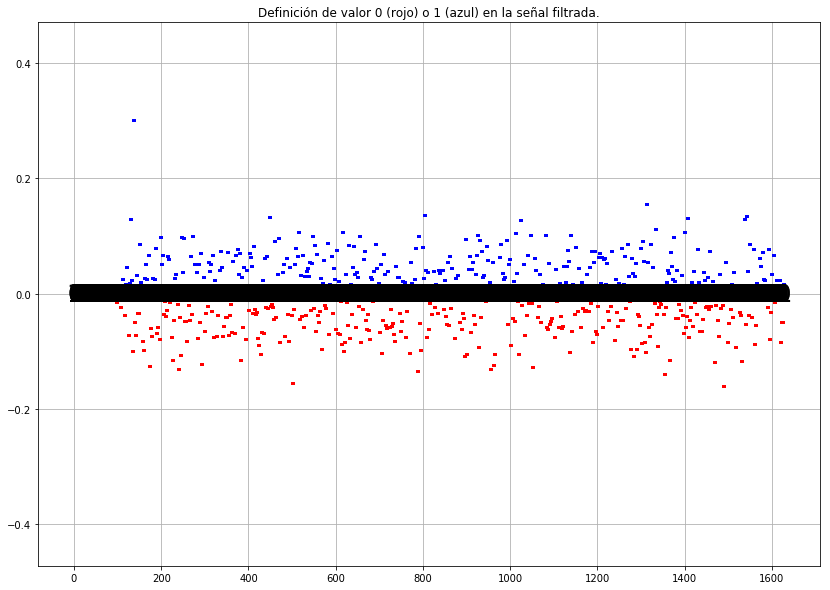

In [2]:
signal = np.load ('signalLowSNR.npy')

N = len(signal)

t = np.linspace (0.0, (N-1)/20, N).flatten ()

plt.figure (figsize=(14, 10))
plt.grid   (True)
plt.title  ('Señal original Low SNR.')
plt.plot   (t, signal)
plt.show   ()

signal = scipy.signal.lfilter (pasaaltotaps, 1.0, signal)
signal = scipy.signal.lfilter (pasabajotaps, 1.0, signal)

plt.figure (figsize=(14, 10))
plt.grid   (True)
plt.title  ('Señal Low SNR filtrada.')
plt.plot   (t, signal)
plt.show   ()


plt.figure (figsize=(14, 10))
plt.grid   (True)
plt.title  ('Definición de valor 0 (rojo) o 1 (azul) en la señal filtrada.')

# Por cada grupo de 20 samples se hace una media de esos 20 y se define si el valor es 0 o 1.
for i in range(0, N, 20):

    pulse_samples = signal[i:i+20]
    pulse = pulse_samples.mean ()
    color = 'b'
    value = '1'
    if pulse < 0.0:
        color = 'r'
        value = '0'
    
    plt.plot ([i/20, (i+20)/20], [pulse, pulse], color, linewidth=3)
    plt.text ((i/20 + (i+20)/20)/2, 0, value, fontsize=24, horizontalalignment='center', verticalalignment='center')

plt.show ()

#### detalle de los valores 0 o 1 en la señal filtrada
<img src="g7c.png" />

#### Tambien es importante aclarar que no obtuve casi ninguna secuencia 10101100 con la señal original (signal.npy). Por otro lado si logre ver la secuencia de bits aplicando el mismo filtrado y metodo de obtener 0 o 1 a la señal de menor SNR (signalLowSNR.npy).